# CNN for Music Classification

This is an implementation of a convolutional neural network (CNN) and applied to a music data set to classify its genre. It is known that CNNs are better applied to image processing and not sound. However, music sound waves are often converted from analog to digital values, and thanks to some data pre-processing it is possible to implement a CNN to work as a genre classification.

Before going into a deep explanation of this notebook I think it is important to mention an amazing programmer, AI music/sound researcher, Valerio Velardo. He has a PhD in music and AI and has some amazing explications about how to manipulate music files as well as some deep learning examples which helped a lot in the development of this project. You can see most of his work at his web page: https://valeriovelardo.com 
 

# The environment
The notebook was implemented in Google Colab (GC) which final files are notebooks in the Google cloud drive. This decision was made thanks to the fact that GC has already installed Keras with TensorFlow, which make our lives so easier in neural networks developments. So, all initial data was uploaded into the cloud folder to be able to work with it. So, the first thing to do is to mount our runtime environment into our project folder. 


In [0]:
# Mount Drive to working folder
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/8° Semestre/Machine Learning/Projects/CNN Music Classifier

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/8° Semestre/Machine Learning/Projects/CNN Music Classifier


# The libraries
Lot’s of libraries are used: os for the file’s navigation, librosa for sound manipulation, math for ceil, json for data storage, numpy for array and list manipulations and keras with tensorflow for neuran networks implementations.


In [0]:
import os
import math
import json
import numpy as np
import IPython.display as ipd
import librosa, librosa.display
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split

dataset = "songs"
data_file = "data.json"

#The data
The data was downloaded from http://marsyas.info/downloads/datasets.html this is a considerably big data set which is super useful as has 10 music genres, 1000 audio tracks, 30 seconds each with a frequency of 22050Hz. The waves main features area frequency and amplitude. Analog to digital conversions give us amplitude with limited bits which are related to the sampling rate scaled in frequency. A sound waveform has more than one signal so, we use Fourier transform (FT) to decompose complex soundwaves. This give us a spectrum of the magnitudes of the frequencies. We compute several FT at different intervals, known as short time Fourier transforms (STFT) for fixed sizes which give a spectrogram which now has time, frequency, and magnitude information. Now, one of the crucial parts to use the CNN instead of other NN is that we use all this to generate the Mel Frequency Cepstral Coefficients (MFCCs) which capture the textural aspects of sound with a frequency domain feature. For this example, we generate 13 coefficients, 10 times per sound. This can be visualized as a matrix (which will be used as if it was an image.)

So, lots of information, but thanks to python libraries we can implement all this with the following code. First we need to declare some global important variables as the data and json file paths, as they are in the same folder, the name is okay, next duration of samples, sampling rates and samples per tracks are used for correctly storing data in the json file. 

This function is the magic, in general aspects it defines a variable which will store the genre names, each song MFCCs and its respective labels. It will go through all data folders, then divide the song into segments and take each into a MFCCs array then it stores it into the data variable with the song label.


In [0]:
# Mel Frequency Cepstral Coefficients
def mfcc(dataset,data_file,n_mfcc=13,n_fft=2048,hop_length=512,num_seg=10):
  # Data with JSON
  data={
      "genres":[],
      "mfcc":[],
      "labels":[]
  }
  # Sampling constants
  duration = 30
  samp_rate = 22050
  samp_track = samp_rate * duration  
  samp_seg = int(samp_track/num_seg)
  mfcc_seg = math.ceil(samp_seg/hop_length)

  # Loop trhough data
  for i, (dirpath,dirnames,filenames) in enumerate(os.walk(dataset)):
    if dirpath is not dataset:
      # Save the name name according to folders
      dirpath_name = dirpath.split("/")
      genre = dirpath_name[-1] 
      data["genres"].append(genre)
      print("Processing: {}".format(genre))
      # Audio data loading
      for f in filenames:
        file_path = os.path.join(dirpath,f)
        signal,sr = librosa.load(file_path,sr= samp_rate)
        # Extracting mfcc per segments
        for s in range(num_seg):
          start = samp_seg * s
          finish = start + samp_seg
          mfcc = librosa.feature.mfcc(signal[start:finish],
                 sr=sr,n_fft=n_fft,n_mfcc=n_mfcc,hop_length=hop_length)
          mfcc = mfcc.T
          # Store mfcc for expected lenght
          if len(mfcc) == mfcc_seg:
            data["mfcc"].append(mfcc.tolist())
            data["labels"].append(i-1)
  with open(data_file,"w") as fp:
    json.dump(data,fp,indent=4)
  return data

This could work only with the data variable, and it will, but the json file makes a backup plan for not having to load and transform the songs each time. That is what this next function is implemented to, in any case something goes wrong and you need to use the file for the next steps. If you do not, we just separate the data and we obtain the MFCCs, labels and names (mapping). It is important to say that each sample is being divided by 10, so we will have 10,000 samples to work with. 


In [0]:
def load_data(dataset_path):
  # import data from file prep
  with open(dataset_path,"r") as fp:
    data = json.load(fp)
  # convert list into np array
  x = np.array(data["mfcc"])
  y = np.array(data["labels"])
  genres = np.array(data["genres"])
  return x,y,genres

def get_data(data):
  x = np.array(data["mfcc"])
  y = np.array(data["labels"])
  genres = np.array(data["genres"])
  return x,y,genres


Finally, we separate our data, but not only in train and test, but also in a validation one. So, we have now 3 types of data, training data, that will be used for the neural network fitting, and the validation data will work as an evaluation parameter all the way trough training and the test data will work to finish testing our NN accuracy. To do this we separate normal train and test data (75% and 25%) and we take the data for validation (20%) form this training data (60% and 15%).

Now, there is a trick over here and its very very important. The data we have work as 2D and yes, our MFCCs have 2 dimensions [Segments*N_MFCCs, N_MFCCs] but we need another one as we are working with CNN. Th depth, and as we only have one value, it will be set as one, that is why we need to add a new axis at the end of all our x values. Now that we have 3 dimensions for our data we can go on and build the neural network.

In [0]:
def prepare_datasets(x,y,test_size,valid_size):
  # Split train and test
  xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=test_size)
  # Split train and validation
  xtrain,xvalid,ytrain,yvalid = train_test_split(xtrain,ytrain,test_size=valid_size)
  # 3d CNN (130,13,1)
  xtrain = xtrain[...,np.newaxis]
  xvalid = xvalid[...,np.newaxis]
  xtest = xtest[...,np.newaxis]
  return xtrain,xvalid,xtest,ytrain,yvalid,ytest

These next functions will not be used until the very end for making a prediction, just to show the process of why this works so well with the CNN. First, we have the soundwave, as for any file we need to have the frequency and sample rate, and with the help of the librosa library we will show this sound waveform.

In [0]:
def waveform(signal,sr):
  librosa.display.waveplot(signal,sr=sr)
  plt.xlabel("Time")
  plt.ylabel("Amplitude")
  plt.title("Waveform")
  plt.show()

The second one represents how the Fast Fourier will work. This will take several steps and step by step make various transformations for us to have the function magnitudes for the frequencies. However, this trend to have a left and right side, we will only keep with the first left half. 

In [0]:
def fast_fourier(signal,sr):
  fft = np.fft.fft(signal)
  mag = np.abs(fft)
  freq = np.linspace(0,sr,len(mag))
  # Keep the left side
  left_freq = freq[:int(len(freq)/2)]
  left_mag = mag[:int(len(mag)/2)]
  plt.plot(left_freq,left_mag)
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  plt.title("Fast Fourier (Spectrum)")
  plt.show()

This is where some things begin to come more complicated. We use the short time Fourier transform with the librosa library to obtain a representation of the frequency trough time thanks to the hops and number of fast Fourier transformations made to gather all information. However, this spectrum does not seem too good, so we transform it to decibels with a logarithmic transform.

In [0]:
def log_spectrogram(signal,sr,n_fft,hop):
  stft = librosa.core.stft(signal,n_fft,hop)
  spectogram = np.abs(stft)
  log_spectrogram = librosa.amplitude_to_db(spectogram)
  librosa.display.specshow(log_spectrogram,sr=sr,hop_length=hop)
  plt.xlabel("Time")
  plt.ylabel("Frequency")
  plt.colorbar()
  plt.title("Log-Spectrogram")
  plt.show()

This is lots, lots of data and could work with it but it will not be efficient. Like this there is something we already mentioned which are the Mel frequency cepstral coefficients, they have a frequency domain feature, and you get several coefficients per time and calculated each frame. It is very similar to the spectrogram and we will use its coefficients. This first function will only plot its MFCCs.

In [0]:
def mfccs_plot(signal,sr,n_fft,hop):
  MFCCs = librosa.feature.mfcc(signal,n_fft=n_fft,hop_length=hop,n_mfcc=13)
  librosa.display.specshow(MFCCs,sr=sr,hop_length=hop)
  plt.xlabel("Time")
  plt.ylabel("MFCCs")
  plt.colorbar()
  plt.title("Mel Frequency Cepstral Coefficients")
  plt.show()

So, same as functions above we need to specify the number of fast Fourier transforms, number of hops and know, the number of coefficients we’ll like, know this can vary from 13 to 40, but as we have lot’s lots of data we’ll have only 13. As well as everything else, we will have 10 MFCCs per song so, we define 10 segments and give each song duration which will be 30 seconds. And so, we divide the song in segments and get the MFCCs and append it to the others. 

In [0]:
def get_mfccs(signal,sr,n_fft,hop):
  x=[]
  # Sampling constants
  n_mfcc=13
  num_seg=10
  duration = 30
  samp_track = sr * duration  
  samp_seg = int(samp_track/num_seg)
  mfcc_seg = math.ceil(samp_seg/hop)
  for s in range(num_seg):
    start = samp_seg * s
    finish = start + samp_seg
    mfcc = librosa.feature.mfcc(signal[start:finish],
            sr=sr,n_fft=n_fft,n_mfcc=n_mfcc,hop_length=hop)
    mfcc = mfcc.T
    # Store mfcc for expected lenght
    if len(mfcc) == mfcc_seg:
      x.append(mfcc.tolist())
  return np.array(x)

Finally, here is a prediction function that will call all this other function at the time we want to predict a certain sound further chosen. But as we will only need one of the MFCCs we choose the middle one and give it format to go into the network prediction and print which genre is according to the index output.

In [0]:
def pred(CNN,file,genres):
  signal,sr = librosa.load(file, sr=22050)
  waveform(signal,sr)
  fast_fourier(signal,sr)
  log_spectrogram(signal,sr,2048,512)
  mfccs_plot(signal,sr,2048,512)
  z = get_mfccs(signal,sr,2048,512)
  x = z[5]
  x = x[np.newaxis,...,np.newaxis]
  pred = CNN.predict(x)
  index = np.argmax(pred)
  print("Predicted: {}".format(genres[index]))

#The Convolutional Neural Network
This function builds the model of the CNN. As normal with keras library we initialize our model and start adding the respective convolutional layers with the data shape values, in this case will be the length of segments, number of MFCCs and the depth which was set to one. We defined our activation function with Relu, make 32 filters with the kernel size of3 by 3. The MaxPool will be with the same dimensions and a stride of 2 by 2 steps. at the end of each one we add a BatchNormalization layer. This is a trick for Normalizing and scaling inputs/activation values. We replicate 2 more blocks of this layers.

Then we have the flatten layer with the fully connected layer. And just for experience we make a dropout to avoid some overfitting with the output layer which will be of 10 neurons according to our mapping data. 


In [0]:
def build_nn(input_shape):
  # Create model Convolution with Maxpool 
  nn = keras.Sequential()
  # 1st Convolution layer
  nn.add(keras.layers.Conv2D(48,(4,4),activation='relu',input_shape=input_shape))
  nn.add(keras.layers.MaxPool2D((4,4),(2,2),'same'))
  nn.add(keras.layers.BatchNormalization())# Normalize activations 
  # 2nd Convolution layer
  nn.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
  nn.add(keras.layers.MaxPool2D((3,3),(2,2),'same'))
  nn.add(keras.layers.BatchNormalization())# Normalize activations 
  # 3rd Convolution layer
  nn.add(keras.layers.Conv2D(16,(2,2),activation='relu',input_shape=input_shape))
  nn.add(keras.layers.MaxPool2D((2,2),(2,2),'same'))
  nn.add(keras.layers.BatchNormalization())# Normalize activations 
  # Flatten layer
  nn.add(keras.layers.Flatten())
  # Fully connected layer
  nn.add(keras.layers.Dense(32,activation='relu'))
  nn.add(keras.layers.Dropout(0.3))# Avoid Overfitting
  # Output layer
  nn.add(keras.layers.Dense(10,activation='softmax'))
  return nn

#The execution
Everything is now ready for the implementation of the CNN. First, we need to load the data from the folder and obtain the genre names, MFCCs and labels. Then we need to divide our inputs, outputs, and genres to finally separate our data into train, validate and test sets.


In [0]:
# Load data as Mel Frequency Cepstral Constants
data = mfcc(dataset,data_file)

Processing: disco
Processing: pop
Processing: country
Processing: hiphop
Processing: classical
Processing: jazz
Processing: metal
Processing: reggae
Processing: rock
Processing: blues


In [0]:
# Get inputs, outputs and Genres names
x,y,genres = get_data(data)

In [0]:
# Prepare for CNN
xtrain,xvalid,xtest,ytrain,yvalid,ytest = prepare_datasets(x,y,0.25,0.2)

Then we define the CNN and pass its respective shape which is for the size of the MFCCs [130,13,1]. Once the CNN is built, we display it so that we see everything is nicely done. It needs to be compiled and then trained. With Keras we can use an optimizer which inn this case is Adam with al learning rate of 0.0001. For the loss function we use a sparse categorical cross entropy which works nicely with this CNN and we want to display the accuracy. This last one will be calculated with the validation data earlier separated.

In [0]:
# Build the Convolutional Neural Network
input_shape = (xtrain.shape[1],xtrain.shape[2],xtrain.shape[3])
CNN = build_nn(input_shape)
CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 10, 48)       816       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 5, 48)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 5, 48)         192       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 3, 32)         13856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 16)         2

In [0]:
# Compile and train CNN 
opti = keras.optimizers.Adam(learning_rate=0.0001)
CNN.compile(opti,"sparse_categorical_crossentropy",['accuracy'])
CNN.fit(xtrain,ytrain,validation_data=(xvalid,yvalid),batch_size=32,epochs=50)

Epoch 1/50
188/188 [==============================] - 15s 80ms/step - loss: 2.5804 - accuracy: 0.1659 - val_loss: 2.1219 - val_accuracy: 0.2700
Epoch 2/50
188/188 [==============================] - 13s 71ms/step - loss: 2.1069 - accuracy: 0.2731 - val_loss: 1.8363 - val_accuracy: 0.3747
Epoch 3/50
188/188 [==============================] - 14s 72ms/step - loss: 1.9055 - accuracy: 0.3385 - val_loss: 1.6551 - val_accuracy: 0.4213
Epoch 4/50
188/188 [==============================] - 14s 72ms/step - loss: 1.7547 - accuracy: 0.3844 - val_loss: 1.5413 - val_accuracy: 0.4553
Epoch 5/50
188/188 [==============================] - 14s 72ms/step - loss: 1.6556 - accuracy: 0.4074 - val_loss: 1.4514 - val_accuracy: 0.4927
Epoch 6/50
188/188 [==============================] - 14s 73ms/step - loss: 1.5826 - accuracy: 0.4407 - val_loss: 1.4103 - val_accuracy: 0.5000
Epoch 7/50
188/188 [==============================] - 14s 74ms/step - loss: 1.5317 - accuracy: 0.4604 - val_loss: 1.3475 - val_accuracy:

Know, to see how it works with data it has never seen before, we evaluate the CNN with the test data.

In [0]:
# Evaluate CNN with the test data
terror,tacc = CNN.evaluate(xtest,ytest,verbose=1)
print("Accouracy on test set is:{}".format(tacc))

79/79 [==============================] - 1s 15ms/step - loss: 0.7318 - accuracy: 0.7527
Accouracy on test set is:0.7527011036872864


Some files are out in the main folder which were randomly taken out form the data set. This is a function that will let us visualize all the process of the data transformation. First, we can hear the song.  

In [0]:
# Play the song
test_song ='tBlues.wav' 
ipd.Audio(test_song)

Over here we will se the soundwave, the Fast Fourier transform which will let us see the spectrum and then the spectrogram and its relationship with the MCCs and why it was taken as an input.

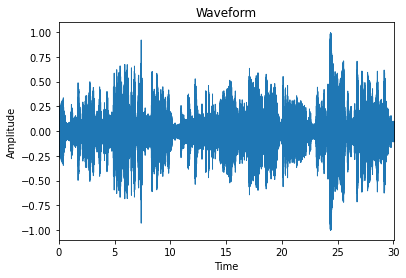

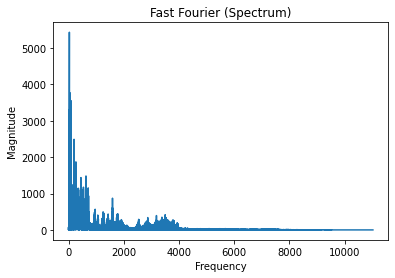

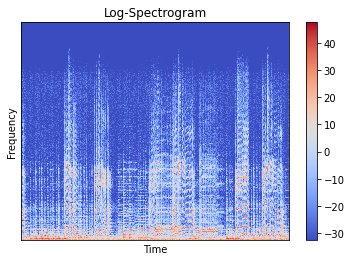

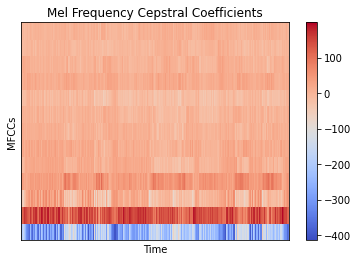

Predicted: blues


In [0]:
# Make a prediction with a song
pred(CNN,test_song,genres)

This final and second prediction This kind of songs can be confused with blues. As we can see the waveform is different, and in the spectrum, we can see that the initial frequency Its way higher. We cannot see much in the spectrogram, but in the MFCCs plot we can see that the are quite similar. For the Country graph there are not enough negative coefficients, that’s why its could get confused with the blues genre.

In [0]:
# Play the song
test_song ='tCountry.wav' 
ipd.Audio(test_song)

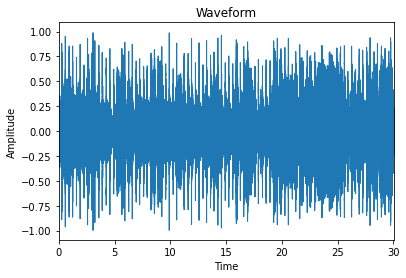

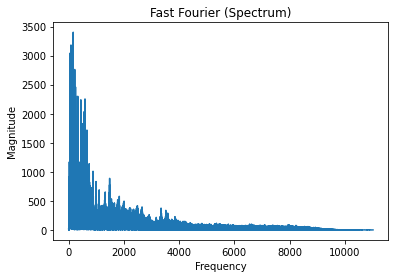

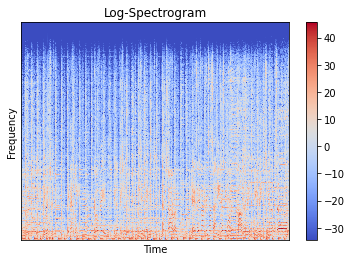

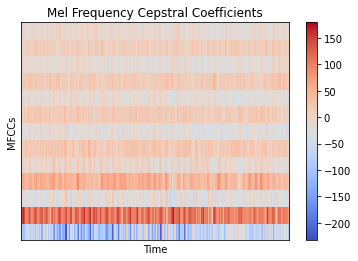

Predicted: country


In [0]:
# Make a prediction with a song
pred(CNN,test_song,genres)